In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 
import os
import netCDF4 as nc
import matplotlib as mpl
import shapefile
import cartopy.crs as ccrs

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal

from shapely.geometry import Polygon

In [2]:
common_years = np.arange(2005,2017,1)

selecao_path = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/selecao.txt' #CHANGE IN CLUSTER
ids_selecao = np.loadtxt(selecao_path, dtype=int)

In [3]:
#get information from the shp file

shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
boundaries = []

shapefile=fiona.open(shapefile_path)

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue
    bounds=shape(geometry).bounds

    #I expand the boundaries of 5000 m (10 pixels)
    xmin=bounds[0]-5000;ymin=bounds[1]-5000;xmax=bounds[2]+5000;ymax=bounds[3]+5000

    #Condition for Twaithes
    if id == 56:
        xmin=bounds[0]-57000;ymin=bounds[1]-50000;xmax=bounds[2]+50000;ymax=bounds[3]+10000


    #Taking the info
    ids.append(id)
    Names.append(name)
    boundaries.append([xmin,xmax,ymin,ymax])

#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'boundaries': boundaries}, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)
#Select just selecao
df = df[np.isin(df.index, ids_selecao)]

In [8]:
#Load the scaling factor
scaling_factor_where_less_than_25 = pd.read_csv('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/scaling_factor.csv', index_col=0)

In [9]:
#load the datasets
directory = '/Users/francesco/Desktop/Thesis/Thickness'

ice_mask = np.load(directory+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
sea_mask = np.load(directory+'/sea_mask.npy', allow_pickle=True)
land_mask = np.load(directory+'/land_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(directory+'/grounded_ice_mask.npy', allow_pickle=True)
borders = np.load(directory+'/new_borders.npy', allow_pickle=True)

#crete the dataframes
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)
borders = pd.DataFrame(borders, index = df.index, columns = common_years)

In [10]:
#Creating a dataset with the available data, selecting multi year if the coverage is less than 25%

list_x = []
list_y = []

velocity_x_tif = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_tif = pd.DataFrame(index = df.index, columns = common_years)

common_years = np.arange(2005,2017,1)

for i in common_years:

    list_x.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VX.tif")
    list_y.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VY.tif")

#calculate the velocity for each year, for each region
velocity_multy_years_x = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_X.tif'
velocity_multy_years_y = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_Y.tif'

for name_x, name_y, year in zip(list_x, list_y, common_years): #for each year

    print(year)

    for id in df.index: #for each region

        xmin,xmax,ymin,ymax = df.boundaries.loc[id]
        merged_mask = (land_mask.loc[id, year] == True) | (ice_mask.loc[id, year] == True) | (grounded_ice_mask.loc[id, year] == True)

        
        with rasterio.open(name_x, crs='EPSG:3031') as src:
               
                window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform) #take the window
                velocity_x = src.read(1, window=window) #read the window as an image


                velocity_x = np.where(merged_mask, velocity_x, np.nan) #Set to nan the values outside ice, land and grounded ice
                velocity_x = np.where(velocity_x == 0, np.nan, velocity_x) #set to nan all the 0 values (and part of the sea)

                #Here I introduce a check for the scaling factor: when is less than 25% i use the scaling factor, otherwise i set it to 0
                #n.b. The scaling factor has been calculated just with the velocity, not with the 2 components (we could make it better)
                if scaling_factor_where_less_than_25.loc[id,str(year)] != 0: 

                    with rasterio.open(velocity_multy_years_x, crs='EPSG:3031') as src:
                         velocity_x = src.read(1, window=window)*scaling_factor_where_less_than_25.loc[id,str(year)]
                
                velocity_x_tif.loc[id, year] = velocity_x


        with rasterio.open(name_y, crs='EPSG:3031') as src:
             
                window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)
                velocity_y = src.read(1, window=window)

                velocity_y = np.where(merged_mask, velocity_y, np.nan)
                velocity_y = np.where(velocity_y == 0, np.nan, velocity_y)

                if scaling_factor_where_less_than_25.loc[id,str(year)] != 0:

                    with rasterio.open(velocity_multy_years_y, crs='EPSG:3031') as src:
                         velocity_y = src.read(1, window=window)*scaling_factor_where_less_than_25.loc[id,str(year)]

                velocity_y_tif.loc[id, year] = velocity_y
      

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [6]:
from skimage.restoration import inpaint

interpolated_velocity_x = pd.DataFrame(index = df.index, columns = common_years)
interpolated_velocity_y = pd.DataFrame(index = df.index, columns = common_years)

interpolated_pixels_x = pd.DataFrame(index = df.index, columns = common_years)
interpolated_pixels_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    print(id)

    for year in common_years:

        if scaling_factor_where_less_than_25.loc[id,str(year)] != 0:
                
                #The sea is 0 in the multi year, we set to nan
                velocity_x_tif.loc[id, year] = np.where(velocity_x_tif.loc[id, year] == 0, np.nan, velocity_x_tif.loc[id, year])
                velocity_y_tif.loc[id, year] = np.where(velocity_y_tif.loc[id, year] == 0, np.nan, velocity_y_tif.loc[id, year])

                #Keep track of the previous information     
                nan_mask_multi_x = np.where(np.isnan(velocity_x_tif.loc[id, year]), True, False)
                nan_mask_multi_y = np.where(np.isnan(velocity_y_tif.loc[id, year]), True, False)

                #With this condition I am setting to nan the pixels which are not nan in the multi year file, but are nan in the single year file
                condition_x_1  = np.logical_and(ice_mask.loc[id, year] == False, np.logical_and(nan_mask_multi_x == False, np.logical_and(grounded_ice_mask.loc[id, year] == False, land_mask.loc[id, year] == False)))
                velocity_x_tif.loc[id, year][condition_x_1] = np.nan

                condition_y_1 = np.logical_and(ice_mask.loc[id, year] == False, np.logical_and(nan_mask_multi_y == False, np.logical_and(grounded_ice_mask.loc[id, year] == False, land_mask.loc[id, year] == False)))
                velocity_y_tif.loc[id, year][condition_y_1] = np.nan

                #Here i look at the pixels which are not nan in the single year file, but are nan in the multi year file. They are the ones I will interpolate in the multi year file
                condition_x_2 = np.logical_and(ice_mask.loc[id,year] == True, nan_mask_multi_x == True)
                condition_y_2 = np.logical_and(ice_mask.loc[id,year] == True, nan_mask_multi_y == True)

                interpolated_pixels_x.loc[id,year] = condition_x_2
                velocity_x_tif.loc[id, year][condition_x_2] = np.nan

                interpolated_pixels_y.loc[id,year] = condition_y_2
                velocity_y_tif.loc[id, year][condition_y_2] = np.nan

                #Now do the actual Inteporlation
                maskX = np.where(np.isnan(velocity_x_tif.loc[id, year]), True, False) 
                maskY = np.where(np.isnan(velocity_y_tif.loc[id, year]), True, False)

                #Interpolate X
                interpolation_x = inpaint.inpaint_biharmonic(velocity_x_tif.loc[id, year], maskX)
                interpolation_x[sea_mask.loc[id, year] == True] = np.nan

                interpolated_velocity_x.loc[id,year] = interpolation_x

                #Inteprolate Y
                interpolation_y = inpaint.inpaint_biharmonic(velocity_y_tif.loc[id, year], maskY)
                interpolation_y[sea_mask.loc[id, year] == True] = np.nan

                interpolated_velocity_y.loc[id,year] = interpolation_y


        maskX = np.where(np.isnan(velocity_x_tif.loc[id, year]), True, False) #Where there is a nan i set it to True
        maskY = np.where(np.isnan(velocity_y_tif.loc[id, year]), True, False)

        interpolated_pixels_x_tmp = np.where(maskX == True, True, False) 
        interpolated_pixels_x_tmp = np.where(sea_mask.loc[id, year] == True, False, interpolated_pixels_x_tmp)

        interpolated_pixel_y_tmp = np.where(maskY == True, True, False)
        interpolated_pixel_y_tmp = np.where(sea_mask.loc[id, year] == True, False, interpolated_pixel_y_tmp)

        interpolated_pixels_x.loc[id, year] = interpolated_pixels_x_tmp
        interpolated_pixels_y.loc[id, year] = interpolated_pixel_y_tmp

        #Interpolate X
        interpolation_x = inpaint.inpaint_biharmonic(velocity_x_tif.loc[id, year], maskX)
        interpolation_x[sea_mask.loc[id, year] == True] = np.nan
        
        interpolated_velocity_x.loc[id,year] = interpolation_x

        #Inteprolate Y
        interpolation_y = inpaint.inpaint_biharmonic(velocity_y_tif.loc[id, year], maskY)
        interpolation_y[sea_mask.loc[id, year] == True] = np.nan

        interpolated_velocity_y.loc[id,year] = interpolation_y


2


NameError: name 'scaling_factor_where_less_than_25' is not defined

In [ ]:
#save the interpolated velocity amd the inteprolated pixels as npy files

'''np.save(os.getcwd()+'/interpolated_velocity_inpaint_x.npy', interpolated_velocity_x)
np.save(os.getcwd()+'/interpolated_velocity_inpaint_y.npy', interpolated_velocity_y)

np.save(os.getcwd()+'/interpolated_pixels_inpaint_x.npy', interpolated_pixels_x)
np.save(os.getcwd()+'/interpolated_pixels_inpaint_y.npy', interpolated_pixels_y)'''

#np.save(os.getcwd()+'/interpolated_velocity_inpaint_x_multi_year.npy', interpolated_velocity_x)
#np.save(os.getcwd()+'/interpolated_velocity_inpaint_y_multi_year.npy', interpolated_velocity_y)

#np.save(os.getcwd()+'/interpolated_pixels_inpaint_x_multi_year.npy', interpolated_pixels_x)
#np.save(os.getcwd()+'/interpolated_pixels_inpaint_y_multi_year.npy', interpolated_pixels_y)

In [5]:
#load the interpolated velocity amd the inteprolated pixels as npy files
'''interpolated_velocity_x = np.load(os.getcwd() + '/npy_files'+'/interpolated_velocity_inpaint_x.npy', allow_pickle=True)
interpolated_velocity_y = np.load(os.getcwd()+ '/npy_files'+'/interpolated_velocity_inpaint_y.npy', allow_pickle=True)

interpolated_pixels_x = np.load(os.getcwd()+ '/npy_files'+'/interpolated_pixels_inpaint_x.npy', allow_pickle=True)
interpolated_pixels_y = np.load(os.getcwd()+ '/npy_files'+'/interpolated_pixels_inpaint_y.npy', allow_pickle=True)


#Create the dataset with the interpolated velocity
interpolated_velocity_x = pd.DataFrame(interpolated_velocity_x, index = df.index, columns = common_years)
interpolated_velocity_y = pd.DataFrame(interpolated_velocity_y, index = df.index, columns = common_years)

interpolated_pixels_x = pd.DataFrame(interpolated_pixels_x, index = df.index, columns = common_years)
interpolated_pixels_y = pd.DataFrame(interpolated_pixels_y, index = df.index, columns = common_years)
'''
#Interpolated velocity multi year load and charge
interpolated_velocity_x = np.load(os.getcwd()+ '/npy_files' +'/interpolated_velocity_inpaint_x_multi_year.npy', allow_pickle=True)
interpolated_velocity_y = np.load(os.getcwd()+ '/npy_files' +'/interpolated_velocity_inpaint_y_multi_year.npy', allow_pickle=True)

interpolated_pixels_x = np.load(os.getcwd()+ '/npy_files' +'/interpolated_pixels_inpaint_x_multi_year.npy', allow_pickle=True)
interpolated_pixels_y = np.load(os.getcwd()+ '/npy_files' +'/interpolated_pixels_inpaint_y_multi_year.npy', allow_pickle=True)

#Create the dataset with the interpolated velocity
interpolated_velocity_x = pd.DataFrame(interpolated_velocity_x, index = df.index, columns = common_years)
interpolated_velocity_y = pd.DataFrame(interpolated_velocity_y, index = df.index, columns = common_years)

interpolated_pixels_x = pd.DataFrame(interpolated_pixels_x, index = df.index, columns = common_years)
interpolated_pixels_y = pd.DataFrame(interpolated_pixels_y, index = df.index, columns = common_years)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/francesco/Desktop/machine_learning_calving_project/Datasets preparation/npy_files/interpolated_velocity_inpaint_x_multi_year.npy'

In [34]:
#Here I am setting to 0 the pixels which are in the sea

for id in df.index:
    for year in common_years:
        interpolated_velocity_x.loc[id, year] = np.where(sea_mask.loc[id, year] == True, 0, interpolated_velocity_x.loc[id, year])
        interpolated_velocity_y.loc[id, year] = np.where(sea_mask.loc[id, year] == True, 0, interpolated_velocity_y.loc[id, year])

#save the dataset as a numpy file
np.save(os.getcwd()+ '/npy_files'+'/interpolated_velocity_inpaint_x_multi_year_sea_set_to_0.npy', interpolated_velocity_x)
np.save(os.getcwd()+ '/npy_files'+'/interpolated_velocity_inpaint_y_multi_year_sea_set_to_0.npy', interpolated_velocity_y)

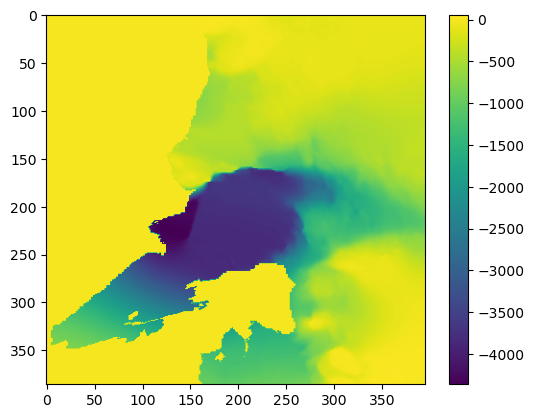

In [32]:
plt.imshow(interpolated_velocity_x.loc[56, 2010])
plt.colorbar()

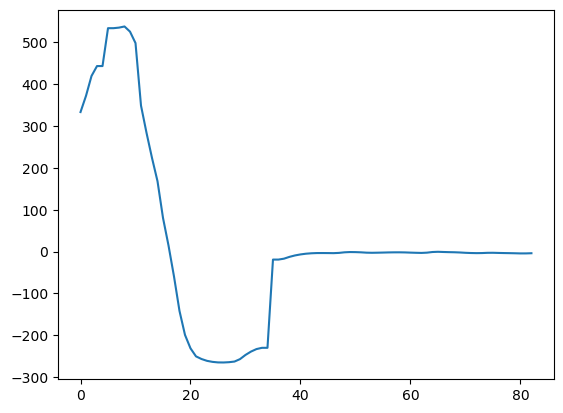

In [21]:
plt.plot(interpolated_velocity_x.loc[10, 2015][100])

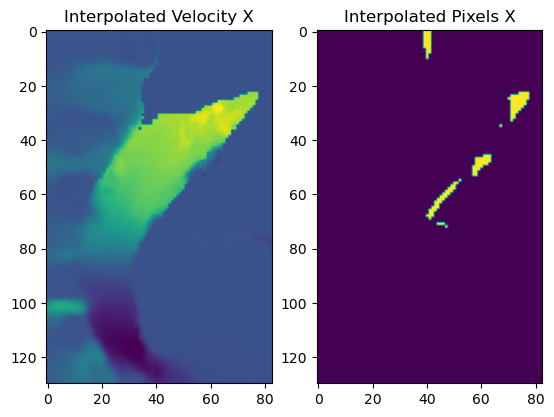

In [27]:
import matplotlib.pyplot as plt
id = 10
year =2011
# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.imshow(interpolated_velocity_x.loc[id, year])
plt.title("Interpolated Velocity X")

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.imshow(interpolated_pixels_x.loc[id, year])
plt.title("Interpolated Pixels X")

plt.show()


In [28]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Define the list of years you want to plot
years = [2005, 2011, 2015]

# Create a PDF file to save the plots
pdf_pages = PdfPages("glacier_plots_interpolated_multi_years_sea_mask.pdf")

# Loop through all glacier IDs
for id in df.index:
    print(id)
    # Create a new figure for each glacier
    fig = plt.figure(figsize=(11, 8))  # Adjust the figure size here

    # Loop through the selected years and create subplots
    for i, year in enumerate(years, start=1):
        plt.subplot(3, 2, 2*i-1)  # 3 rows, 2 columns, plot i (velocity)
        plt.imshow(interpolated_velocity_x.loc[id, year])
        title = f"ID {id}, Year {year} - Velocity"
        if scaling_factor_where_less_than_25.loc[id, str(year)] != 0:
            title += ", SCALED MULTI-YEAR"
        plt.title(title)

        plt.subplot(3, 2, 2*i)  # 3 rows, 2 columns, plot i (interpolated)
        plt.imshow(interpolated_pixels_x.loc[id, year])
        title = f"ID {id}, Year {year} - Interpolated Pixels"
        if scaling_factor_where_less_than_25.loc[id, str(year)] != 0:
            title += ", SCALED MULTI-YEAR"
        plt.title(title)

    # Adjust the spacing to prevent overlapping titles
    plt.tight_layout()

    # Save the current figure as a page in the PDF
    pdf_pages.savefig(fig)
    plt.close()

# Close the PDF file
pdf_pages.close()


2
3
4
6
7
8
10
12
15
16
17
18
19
24
26
29
30
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
48
50
52
53
54
55
56
57
58
60
61
62
63
64
65
66
67
68
69
70
71
72
73
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
92
93
95
96
97
98
99
100
101
102
104
105
107
108
109
110
111
112
114
115
116
117
118
119
120
121
122
123
124
125
127
129
131
132
135
136
139
140
143
144
145
146
147
148
156
157
158
159
160
161
162
163
164
166
169
170
